## Import Packages and Set Directories¶

In [2]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
sample_dir = os.path.join(base_dir, 'data', 'processed', 'sample_stock')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [3]:
# Read the stock data into dataframes
price_1_file = os.path.join(data_dir, 'price_1.csv')
price_2_file = os.path.join(data_dir, 'price_2.csv')
price_3_file = os.path.join(data_dir, 'price_3.csv')
price_4_file = os.path.join(data_dir, 'price_4.csv')
df_1 = pd.read_csv(price_1_file, index_col='Date')
df_2 = pd.read_csv(price_2_file, index_col='Date')
df_3 = pd.read_csv(price_3_file, index_col='Date')
df_4 = pd.read_csv(price_4_file, index_col='Date')

# Read Business cycle data
bc_df = pd.read_csv(os.path.join(data_dir, 'business_cycle_divided.csv'))
# Format business cycle Year_Month
bc_df['Year_Month'] = pd.to_datetime(bc_df['Year'].astype(str) + '-' + bc_df['Month'].astype(str))
bc_df['Year_Month'] = bc_df['Year_Month'].dt.to_period('M')
bc_df['Year_Month'] = bc_df['Year_Month'].astype('str')
bc_df.drop(columns=['Year', 'Month', 'Cof_idx', 'Recession'], inplace=True)

# Read factor data
factors_weekly_df = pd.read_csv(os.path.join(factor_dir, 'factors_weekly.csv'))
factors_monthly_df = pd.read_csv(os.path.join(factor_dir, 'factors_monthly.csv'))

## 1. Optimal Portfolios across Cycles¶

### 1.1 Construct Optimal Portfolios across Cycles¶

Since cycle 4 has the highest number of stocks, the inverse of the covariance matrix become more sensitive to high correlation stocks. Therefore, we have to set the correlation threshold lower to create optimized portfolio.

In [3]:
# Initialize OptimalPortfolios class
num_pfo = 5
corr_threshold = 0.99
ef1 = OptimalPortfolios(df_1, num_pfo, corr_threshold)
ef2 = OptimalPortfolios(df_2, num_pfo, corr_threshold)
ef3 = OptimalPortfolios(df_3, num_pfo, corr_threshold)
ef4 = OptimalPortfolios(df_4, num_pfo, corr_threshold**5)  # lower the threshold for optimization

# Calculate efficient frontier
ef_instances = [ef1, ef2, ef3, ef4]
for ef in ef_instances:    
    ef.calculate_efficient_frontier()

5 stocks removed, 279 stocks remain.
0 stocks removed, 663 stocks remain.
56 stocks removed, 787 stocks remain.
324 stocks removed, 867 stocks remain.


Combine the optimal portfolios from different cycles into a single dataset. Add a new column named 'Cycle' to indicate the specific cycle each portfolio belongs to. Then, save the daily, weekly, monthly, and yearly returns of these combined optimal portfolios into separate CSV files.

In [4]:
ef_combined_daily = ef1.daily_return.head(0).copy()
ef_combined_weekly = ef1.weekly_return.head(0).copy()
ef_combined_monthly = ef1.monthly_return.head(0).copy()
ef_combined_annual = ef1.annual_return.head(0).copy()

for idx, ef in enumerate(ef_instances):
    ef_daily = ef.daily_return.copy().reset_index()
    ef_weekly = ef.weekly_return.copy().reset_index()
    ef_monthly = ef.monthly_return.copy().reset_index()
    ef_annual = ef.annual_return.copy().reset_index()    
    ef_daily['Cycle'] = idx + 1
    ef_weekly['Cycle'] = idx + 1
    ef_monthly['Cycle'] = idx + 1
    ef_annual['Cycle'] = idx + 1
    # Combine the dataframes
    ef_combined_daily = pd.concat([ef_combined_daily, ef_daily]).drop_duplicates(subset='Date', keep='first')
    ef_combined_weekly = pd.concat([ef_combined_weekly, ef_weekly]).drop_duplicates(subset='Year_Week', keep='first')
    ef_combined_monthly = pd.concat([ef_combined_monthly, ef_monthly]).drop_duplicates(subset='Year_Month', keep='first')
    ef_combined_annual = pd.concat([ef_combined_annual, ef_annual]).drop_duplicates(subset='Date', keep='first')

# Change decimals into percentage
cols_to_multiply = ef_combined_daily.columns.difference(['Date', 'Cycle'])
ef_combined_daily[cols_to_multiply] = ef_combined_daily[cols_to_multiply] * 100
ef_combined_weekly[cols_to_multiply] = ef_combined_weekly[cols_to_multiply] * 100
ef_combined_monthly[cols_to_multiply] = ef_combined_monthly[cols_to_multiply] * 100
ef_combined_annual[cols_to_multiply] = ef_combined_annual[cols_to_multiply] * 100
    
# Set the index
ef_combined_daily.set_index('Date', inplace=True)
ef_combined_weekly.set_index('Year_Week', inplace=True)
ef_combined_monthly.set_index('Year_Month', inplace=True)
ef_combined_annual.set_index('Date', inplace=True)


Store to CSV files

In [5]:
daily_path = os.path.join(sample_dir, 'optimal_pfo_return_daily.csv')
weekly_path = os.path.join(sample_dir, 'optimal_pfo_return_weekly.csv')
monthly_path = os.path.join(sample_dir, 'optimal_pfo_return_monthly.csv')
yearly_path = os.path.join(sample_dir, 'optimal_pfo_return_yearly.csv')
# ef_combined_daily.to_csv(daily_path)
# ef_combined_weekly.to_csv(weekly_path)
# ef_combined_monthly.to_csv(monthly_path)
# ef_combined_annual.to_csv(yearly_path)

### 1.2 Visualization on the Optimal Portfolios 

From the line chart below, we can observe that the portfolios within each cycle follow the same monthly return trend. This outcome aligns with our objective of capturing the preferences of different types of investors. Additionally, it's noticeable that Portfolio 3, characterized by high risk and high return, typically experiences the greatest variability in monthly returns. This observation is in line with our expectations and further corroborates our findings from the efficient frontier analysis.

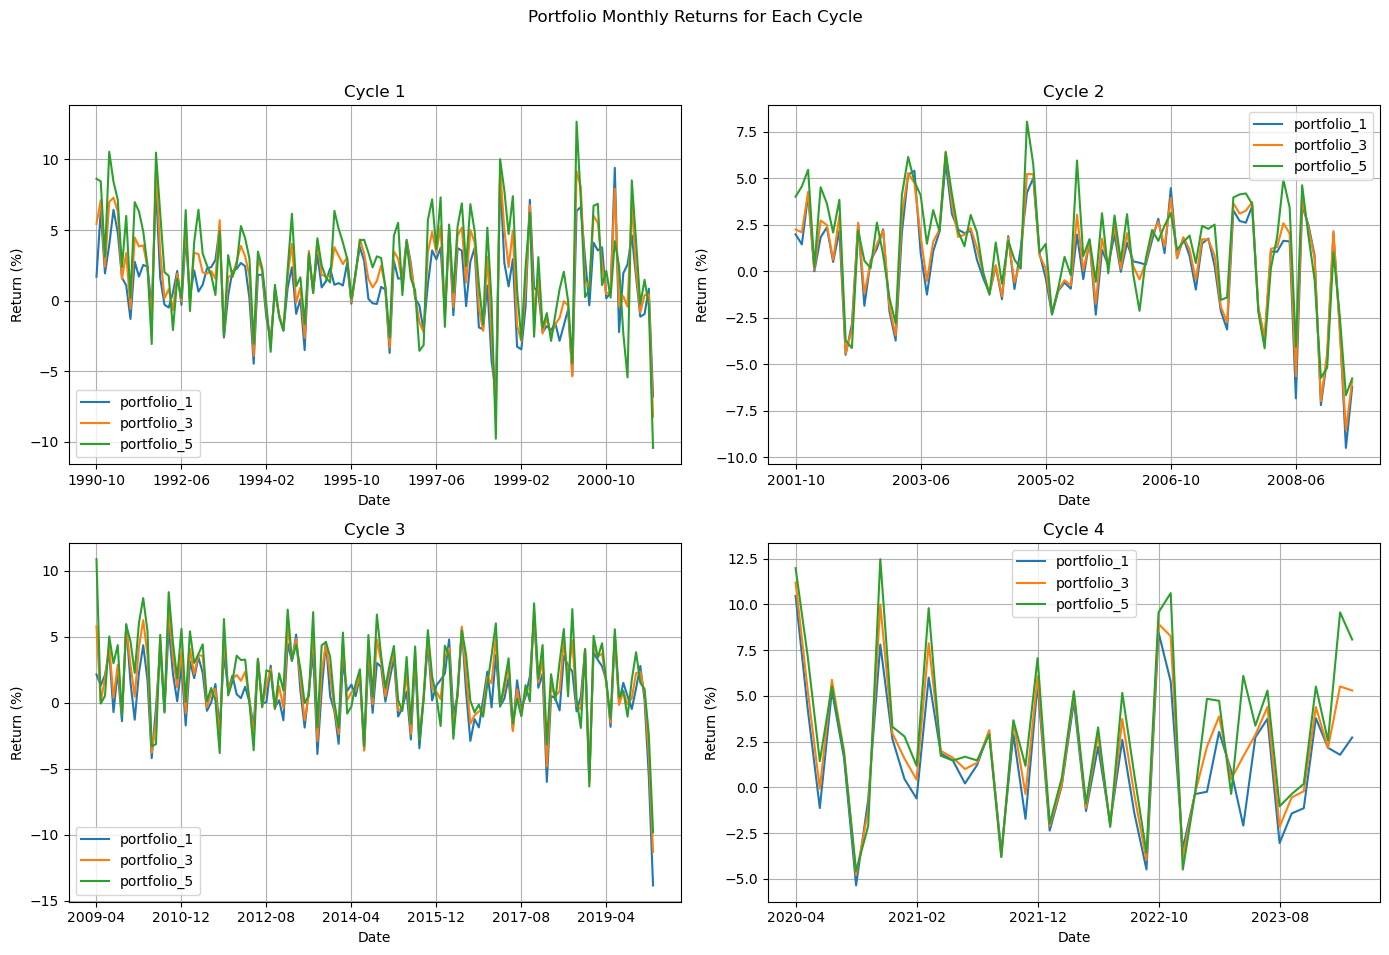

In [6]:
# Creating subplots for each cycle
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Portfolio Monthly Returns for Each Cycle')
cycles = ef_combined_monthly['Cycle'].unique()
for i, cycle in enumerate(cycles):
    ax = axes[i//2, i%2]
    cycle_data = ef_combined_monthly[ef_combined_monthly['Cycle'] == cycle]
    
    cycle_data[['portfolio_1', 'portfolio_3', 'portfolio_5']].plot(ax=ax)
    ax.set_title(f'Cycle {int(cycle)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return (%)')
    ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
# plt.savefig(os.path.join(graph_dir, 'optimal_monthly_returns_cycles.png'))
plt.show()

We can create graphs to observe the number of stocks utilized in each portfolio. It is evident that most portfolios comprise approximately 30 to 70 stocks. This observation suggests that removing some highly correlated stocks might not significantly impact our analysis, as less than a quarter of the stocks are typically employed in these portfolios.

{'1990-2001': [64, 54, 34], '2001-2009': [32, 30, 28], '2009-2020': [38, 42, 35], '2020-2024': [47, 41, 33]}


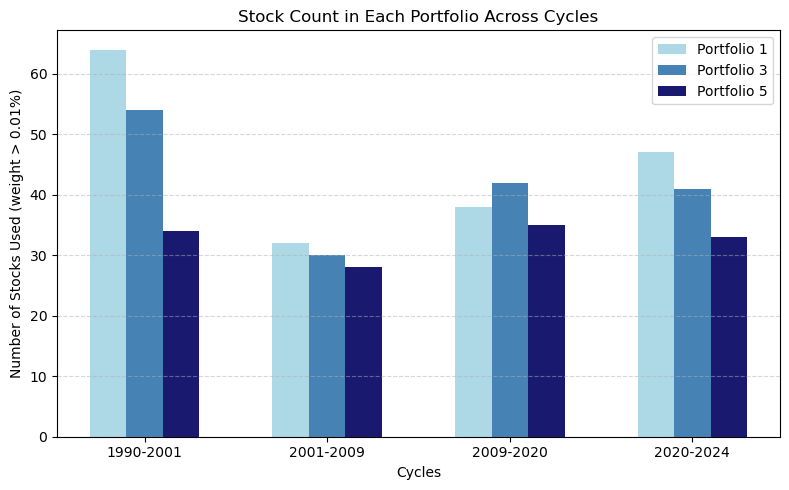

In [7]:
# Calculate number of stocks used for each portfolio
ticker_counts = {}
threshold = 1e-4
ef_names = ['1990-2001', '2001-2009', '2009-2020', '2020-2024']

# Loop through each instance and each portfolio
for ef_name, ef in zip(ef_names, ef_instances):    
    counts = []
    for i in range(1, num_pfo + 1, 2):
        count = len(ef.weight_df[abs(ef.weight_df[f'weight_{i}']) > threshold])
        counts.append(count)
    ticker_counts[ef_name] = counts
print(ticker_counts)

# Create a bar chart
fig, ax = plt.subplots(figsize=(8,5))
positions = range(len(ef_names))
width = 0.2
colors = ['lightblue', 'steelblue', 'midnightblue']
for i in range(3):
    pos = [p + width*i for p in positions]
    counts = [ticker_counts[ef_name][i] for ef_name in ef_names]
    ax.bar(pos, counts, width, label=f'Portfolio {2*i+1}', color=colors[i % len(colors)])

# Adding labels and title
ax.set_xlabel('Cycles')
ax.set_ylabel('Number of Stocks Used (weight > 0.01%)')
ax.set_title('Stock Count in Each Portfolio Across Cycles')
ax.set_xticks([p + width for p in range(len(ef_names))])
ax.set_xticklabels(ef_names)
ax.legend()
ax.yaxis.grid(True, alpha=0.5, linestyle='--')
# plt.savefig(os.path.join(graph_dir, 'optimal_portfolios_count.png'))
plt.tight_layout()
plt.show()

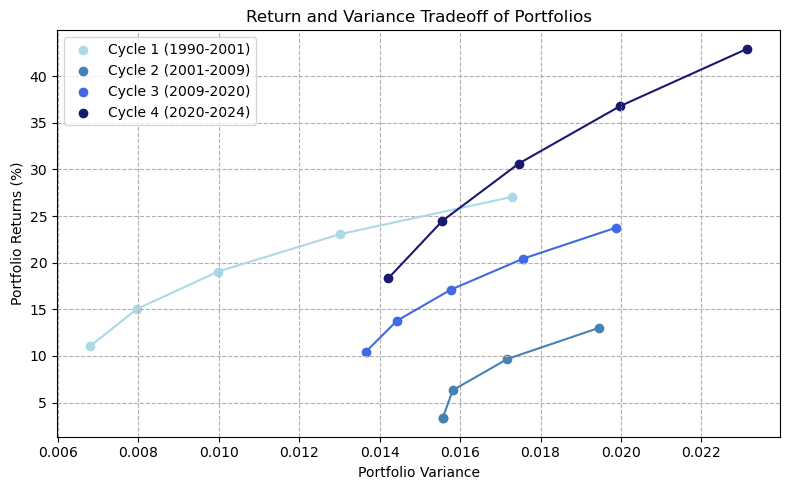

In [8]:
# Plotting for each portfolio
plt.figure(figsize=(8,5))
for ef, color, label in zip([ef1, ef2, ef3, ef4], ['lightblue', 'steelblue', 'royalblue', 'midnightblue'],
                            ['Cycle 1 (1990-2001)','Cycle 2 (2001-2009)','Cycle 3 (2009-2020)','Cycle 4 (2020-2024)']):
    pfo_vars = np.array(ef.pfo_vars)
    pfo_returns = np.array(ef.pfo_returns) * 100
    plt.scatter(pfo_vars, pfo_returns, color=color, label=label)
    plt.plot(pfo_vars, pfo_returns, color=color)

# Setting labels and title
plt.xlabel('Portfolio Variance')
plt.ylabel('Portfolio Returns (%)')
plt.title('Return and Variance Tradeoff of Portfolios')
plt.legend()
plt.grid(True, linestyle='--')

# Show and save the plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'optimal_portfolios_tradeoff.png'))
plt.show()

## 2. Optimal Portfolios under Different Economic Conditions

### 2.1 Create Covariates for each Business Phases

Under each of the four cycles, we can divde it into **Recovery**, **Expansion**, **Downturn**, and **Depression**. We will create different portfolios for each sub-cycle.

In [4]:
def create_week_column(df_orginal):
    """
    Create a Year_Week column using df's Date column and drop 'Date column'
    """
    df_tmp = df_orginal.copy()
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    df_tmp['Week'] = df_tmp['Date'].dt.isocalendar().week  
    df_tmp['Year'] = df_tmp['Date'].dt.isocalendar().year
    df_tmp['Year_Week'] = df_tmp['Year'].astype(str) + '-' + df_tmp['Week'].astype(str).str.zfill(2)
    df_tmp.drop(columns=['Year', 'Week', 'Date'], inplace=True)
    return df_tmp


def create_phase_pfo(phase, data_dict):
    """
    Constructs and merges optimal stock portfolios with financial factor data for a specified business cycle phase.
    This function filters stock data for the given phase, computes optimal portfolios, and merges the portfolio returns with financial factor data. 
    It calculates excess returns over the risk-free rate and reorganizes the data for further analysis.
    Args:
        phase (str): The business cycle phase to filter the stock data.
        data_dict (dict): A dictionary containing the following key-value pairs:
            - 'bc_df': DataFrame with business cycle information.
            - 'stock_dfs': List of DataFrames with stock data.
            - 'factors_week': DataFrame with weekly financial factor data.
            - 'factors_month': DataFrame with monthly financial factor data.
            - 'num_pfo': Integer indicating the number of portfolios to create.
            - 'corr_threshold': Float for the correlation threshold in portfolio construction.
    Returns:
        tuple: Contains three DataFrames -
            1. Weekly merged stock and factor data with excess returns.
            2. Monthly merged stock and factor data with excess returns.
            3. Daily returns data of the portfolios for the phase.
    """
    # Extracting values from the dictionary
    bc_df = data_dict['bc_df']
    stock_dfs = data_dict['stock_dfs']
    factors_week = data_dict['factors_week']
    factors_month = data_dict['factors_month']
    num_pfo = data_dict['num_pfo']
    corr_threshold = data_dict['corr_threshold']
    
    # Loop over stock_dfs
    print(f"***{phase} Phase***")
    for idx, stock_df in enumerate(stock_dfs):
        # Filter current phase data
        phase_df = stock_df.copy().reset_index()
        phase_df['Year_Month'] = pd.to_datetime(phase_df['Date']).dt.to_period('M')
        phase_df['Year_Month'] = phase_df['Year_Month'].astype('str')
        phase_df = pd.merge(phase_df, bc_df, how='inner', on='Year_Month')
        phase_df = phase_df[phase_df[phase] == 1].set_index('Date')
        # Remove phases and Year_Month columns
        cols_to_keep = stock_df.columns
        phase_df = phase_df[cols_to_keep]    
        # Consturct optimal portfolios for current phase
        ef_phase_stock = OptimalPortfolios(phase_df, num_pfo, corr_threshold)
        ef_phase_stock.calculate_efficient_frontier()
        # Extract return data from class
        ef_daily = ef_phase_stock.daily_return.reset_index()
        ef_weekly = ef_phase_stock.weekly_return.reset_index()
        ef_monthly = ef_phase_stock.monthly_return.reset_index()
        # Create header if starting 
        if idx == 0:
            ef_phase_daily = ef_daily.head(0)
            ef_phase_weekly = ef_weekly.head(0)
            ef_phase_monthly = ef_monthly.head(0)
        # Concat the dataframe and drop duplicates
        ef_phase_daily = pd.concat([ef_phase_daily, ef_daily]).drop_duplicates(subset='Date', keep='last')
        ef_phase_weekly = pd.concat([ef_phase_weekly, ef_weekly]).drop_duplicates(subset='Year_Week', keep='last')
        ef_phase_monthly = pd.concat([ef_phase_monthly, ef_monthly]).drop_duplicates(subset='Year_Month', keep='last')

    # Reset Index
    ef_phase_daily = ef_phase_daily.set_index('Date')
    ef_phase_weekly = ef_phase_weekly.set_index('Year_Week')
    ef_phase_monthly = ef_phase_monthly.set_index('Year_Month')
    # Change decimals into percentage
    ef_phase_daily = ef_phase_daily * 100
    ef_phase_weekly = ef_phase_weekly * 100
    ef_phase_monthly = ef_phase_monthly * 100
    # Add phase column
    ef_phase_daily['Phase'] = phase
    ef_phase_weekly['Phase'] = phase
    ef_phase_monthly['Phase'] = phase
    # Reset index to merge with factors
    ef_phase_daily = ef_phase_daily.reset_index()
    ef_phase_weekly = ef_phase_weekly.reset_index()
    ef_phase_monthly = ef_phase_monthly.reset_index()
    factors_weekly_tmp = create_week_column(factors_week)
    
    # Merge stock df with factor df
    covariates_weekly = pd.merge(ef_phase_weekly, factors_weekly_tmp, how='inner', on='Year_Week')
    covariates_monthly = pd.merge(ef_phase_monthly, factors_month, how='inner', on='Year_Month')
    # Calculate excess return
    pfo_col_names = []  # create tmp list to re-order columns
    for pfo in range(1, num_pfo+1):
        covariates_weekly[f'R{pfo}-RF'] = covariates_weekly[f'portfolio_{pfo}'] - covariates_weekly['RF']
        covariates_monthly[f'R{pfo}-RF'] = covariates_monthly[f'portfolio_{pfo}'] - covariates_monthly['RF']
        covariates_weekly.drop(columns=[f'portfolio_{pfo}'], inplace=True)   
        pfo_col_names.append(f'R{pfo}-RF')  # append the pfo name to list  
    # Reorder columns 
    cols_remaining = covariates_weekly.columns.difference(['Year_Week','Phase'] + pfo_col_names).tolist()
    covariates_weekly = covariates_weekly[['Phase', 'Year_Week'] +  pfo_col_names + cols_remaining]
    covariates_monthly = covariates_monthly[['Phase', 'Year_Month'] + pfo_col_names + cols_remaining]
    covariates_weekly.drop(columns=['RF'], inplace=True)  # drop RF column
    covariates_monthly.drop(columns=['RF'], inplace=True)  # drop RF column
    return covariates_weekly, covariates_monthly, ef_phase_daily

Create optimal portfolios for each phase. Combine the dataframes and save to csv

In [5]:
# Input for the function create_phase_pfo
inputs = {'bc_df': bc_df,
          'stock_dfs': [df_1, df_2, df_3, df_4],
          'factors_week': factors_weekly_df,
          'factors_month': factors_monthly_df,
          'num_pfo': 5,
          'corr_threshold': 0.99}

# Generate weekly, monthly and daily covariates for each phases
recovery_w, recovery_m, recovery_d = create_phase_pfo('Recovery', inputs)
expansion_w, expansion_m, expansion_d = create_phase_pfo('Expansion', inputs)
downturn_w, downturn_m, downturn_d = create_phase_pfo('Downturn', inputs)
depression_w, depression_m, depression_d = create_phase_pfo('Depression', inputs)

# Combine dataframes across phases
combined_m = pd.concat([recovery_m, expansion_m, downturn_m, depression_m], ignore_index=True)
combined_w = pd.concat([recovery_w, expansion_w, downturn_w, depression_w], ignore_index=True)
combined_d = pd.concat([recovery_d, expansion_d, downturn_d, depression_d])

# Save to csv
# combined_m.to_csv(os.path.join(data_dir, 'covariates_monthly.csv'), index=False)
# combined_w.to_csv(os.path.join(data_dir, 'covariates_weekly.csv'), index=False)

***Recovery Phase***
0 stocks removed, 284 stocks remain.
0 stocks removed, 663 stocks remain.
0 stocks removed, 843 stocks remain.
131 stocks removed, 1060 stocks remain.
***Expansion Phase***
16 stocks removed, 268 stocks remain.
6 stocks removed, 657 stocks remain.
118 stocks removed, 725 stocks remain.
4 stocks removed, 1187 stocks remain.
***Downturn Phase***
9 stocks removed, 275 stocks remain.
13 stocks removed, 650 stocks remain.
89 stocks removed, 754 stocks remain.
6 stocks removed, 1185 stocks remain.
***Depression Phase***
122 stocks removed, 162 stocks remain.
0 stocks removed, 663 stocks remain.
486 stocks removed, 357 stocks remain.
46 stocks removed, 1145 stocks remain.


### 2.2 Check covariates

We first check abnormal return patterns, then compare the returns between portfolios with different returns druing each phase. If there are portfolios experiencing identical returns, something may be wrong with the code.

In [6]:
filtered_d = combined_d.query('abs(`portfolio_1`) > 10 or abs(`portfolio_3`) > 10 or abs(`portfolio_5`) > 10')
filtered_w = combined_w.query('abs(`R1-RF`) > 15 or abs(`R3-RF`) > 15 or abs(`R5-RF`) > 15')
filtered_m = combined_m.query('abs(`R1-RF`) > 20 or abs(`R3-RF`) > 20 or abs(`R5-RF`) > 20')

print(f"\n***Abnormal Returns***\n")
display(filtered_d)
display(filtered_w)
display(filtered_m)

print(f"\n***Portfolios with Close Weeky Returns***\n")
filtered_rows1 = combined_w[abs(combined_w['R1-RF'] - combined_w['R3-RF']) < 1e-4]
filtered_rows2 = combined_w[abs(combined_w['R3-RF'] - combined_w['R5-RF']) < 1e-4]
display(filtered_rows1)
display(filtered_rows2)


***Abnormal Returns***



,Date,portfolio_1,portfolio_2,portfolio_3,portfolio_4,portfolio_5,Phase
1137,2020-03-09,-11.628840,-11.476393,-11.381867,-11.306740,-11.242624,Depression
1140,2020-03-12,-11.810078,-11.721058,-11.621458,-11.518332,-11.411274,Depression
1142,2020-03-16,-12.823374,-12.689235,-12.601322,-12.509093,-12.413104,Depression
1144,2020-03-18,-11.132166,-11.028012,-10.908140,-10.790433,-10.659535,Depression


,Phase,Year_Week,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
1677,Depression,2020-11,-17.862704,-17.582402,-17.404184,-17.240741,-17.075608,0.821484,8.296838,5.6322,-3.008703,1.4211,-9.220104,-6.7367,3.179393,-9.692456,1.481885,3.7464,-7.633105
1678,Depression,2020-12,-15.785944,-15.484849,-15.243500,-14.999711,-14.738288,-1.597365,4.561784,4.3706,-6.054652,-0.6076,-4.641125,-0.3106,-2.422140,-14.552961,-2.270485,0.7754,0.734632
1681,Depression,2020-15,18.215601,18.958088,19.804883,20.684455,21.565132,-1.295398,-10.312948,-3.0748,6.994933,-2.0955,14.585306,6.0028,-4.926813,12.336464,1.758315,-0.5967,4.634574


,Phase,Year_Month,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
388,Depression,2020-04,16.554938,19.98495,23.51442,27.108007,30.712312,-1.0,-6.186851,-2.7459,-1.33,-0.1436,23.238284,3.3984,-5.23,13.65,2.72,-1.9135,2.56



***Portfolios with Close Weeky Returns***



,Phase,Year_Week,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
1424,Downturn,2022-10,-1.689736,-1.690453,-1.689659,-1.64931,-1.57084,0.488042,-2.122516,-2.5826,2.041452,2.0518,0.457043,1.9253,1.051891,-2.860169,-1.572395,-1.3933,1.889744


,Phase,Year_Week,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
441,Expansion,1999-37,-1.68247,-1.638315,-1.588946,-1.599827,-1.588931,-0.231743,1.499376,0.4332,0.03403,0.1027,-0.057101,0.1477,0.447054,-1.428951,0.399302,0.6621,-0.051101


### 2.3 Visualization and EDA for Covariates

#### 2.3.1 First check CAGR and variance for each phases


CAGR for Efficient Portfolios(%):


,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF
Recovery,12.7959,16.8469,20.9788,25.1576,29.4629
Expansion,10.4345,14.0043,17.7475,21.4591,25.0620
Depression,0.7426,3.1554,5.0904,6.8646,8.5153
Downturn,7.3814,10.1292,12.8659,15.7009,18.3656



Variance for Efficient Portfolios(%):


,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF
Recovery,85.2103,100.6061,121.4902,151.1151,188.4332
Expansion,75.0330,100.9088,139.1109,192.8118,259.3105
Depression,228.1263,202.6144,195.9620,201.0155,217.3544
Downturn,57.7355,80.9974,114.4797,151.4594,195.2920


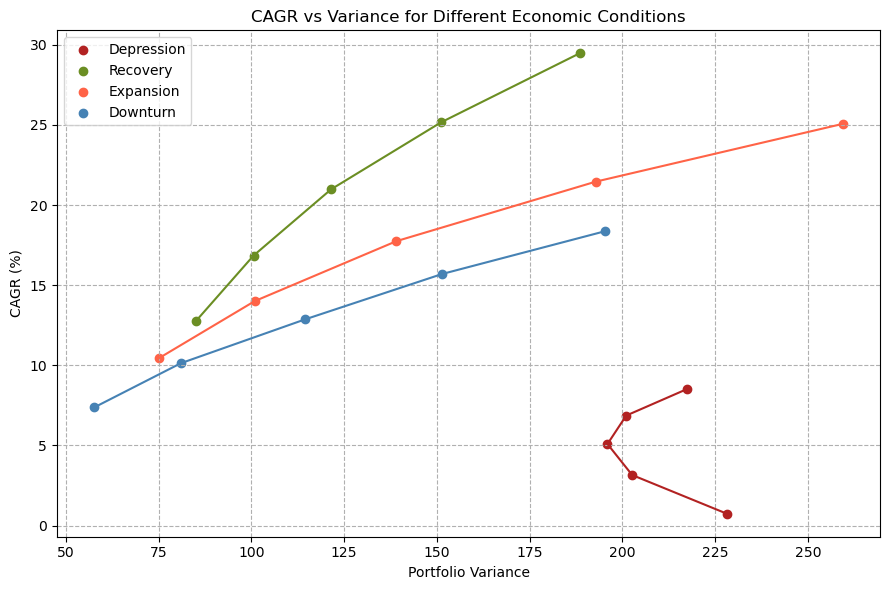

In [9]:
def compound_returns(x):
    return (np.prod(1 + x/100) - 1) * 100

def calculate_cagr(x):
    n = len(np.unique(x.index))
    return ((np.prod(1 + x/100) ** (1/n)) - 1) * 100

def calculate_variance(x):
    return np.var(x)

def round_to_four(x):
    return round(x, 4)

# Group by year for each phase and calculate annual return
phase_pfo_w = combined_w[['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF']].copy()
phase_pfo_w['Year'] = phase_pfo_w['Year_Week'].str.split('-').str[0]
phase_pfo_w.drop(columns=['Year_Week'], inplace=True)
grouped_compound_returns = phase_pfo_w.groupby(['Phase', 'Year']).agg(compound_returns)
grouped_compound_returns

# Calculate CAGR and variance for each phase
phases = ['Recovery', 'Expansion', 'Depression', 'Downturn']
results_cagr = pd.DataFrame(index=phases, columns=['R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF'])
results_variance = pd.DataFrame(index=phases, columns=['R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF'])
for phase in phases:
    phase_data = grouped_compound_returns.xs(phase, level='Phase')
    results_cagr.loc[phase] = phase_data.apply(calculate_cagr)
    results_variance.loc[phase] = phase_data.apply(calculate_variance)
results_cagr_rounded = results_cagr.applymap(round_to_four)
results_variance_rounded = results_variance.applymap(round_to_four)

# Display results
print("\nCAGR for Efficient Portfolios(%):")
display(results_cagr_rounded)
print("\nVariance for Efficient Portfolios(%):")
display(results_variance_rounded)

# Plotting for each phase
colors = ['firebrick', 'olivedrab', 'tomato', 'steelblue']
labels = ['Depression', 'Recovery', 'Expansion',  'Downturn']
plt.figure(figsize=(9, 6))
for label, color in zip(labels, colors):
    cagr_values = results_cagr.loc[label].values
    variance_values = results_variance.loc[label].values
    plt.scatter(variance_values, cagr_values, color=color, label=label)
    plt.plot(variance_values, cagr_values, color=color)

# Setting labels and title; show and save plot
plt.xlabel('Portfolio Variance')
plt.ylabel('CAGR (%)')
plt.title('CAGR vs Variance for Different Economic Conditions')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'ef_by_phase.png'))
plt.show()


#### 2.3.2 Plot monthly return

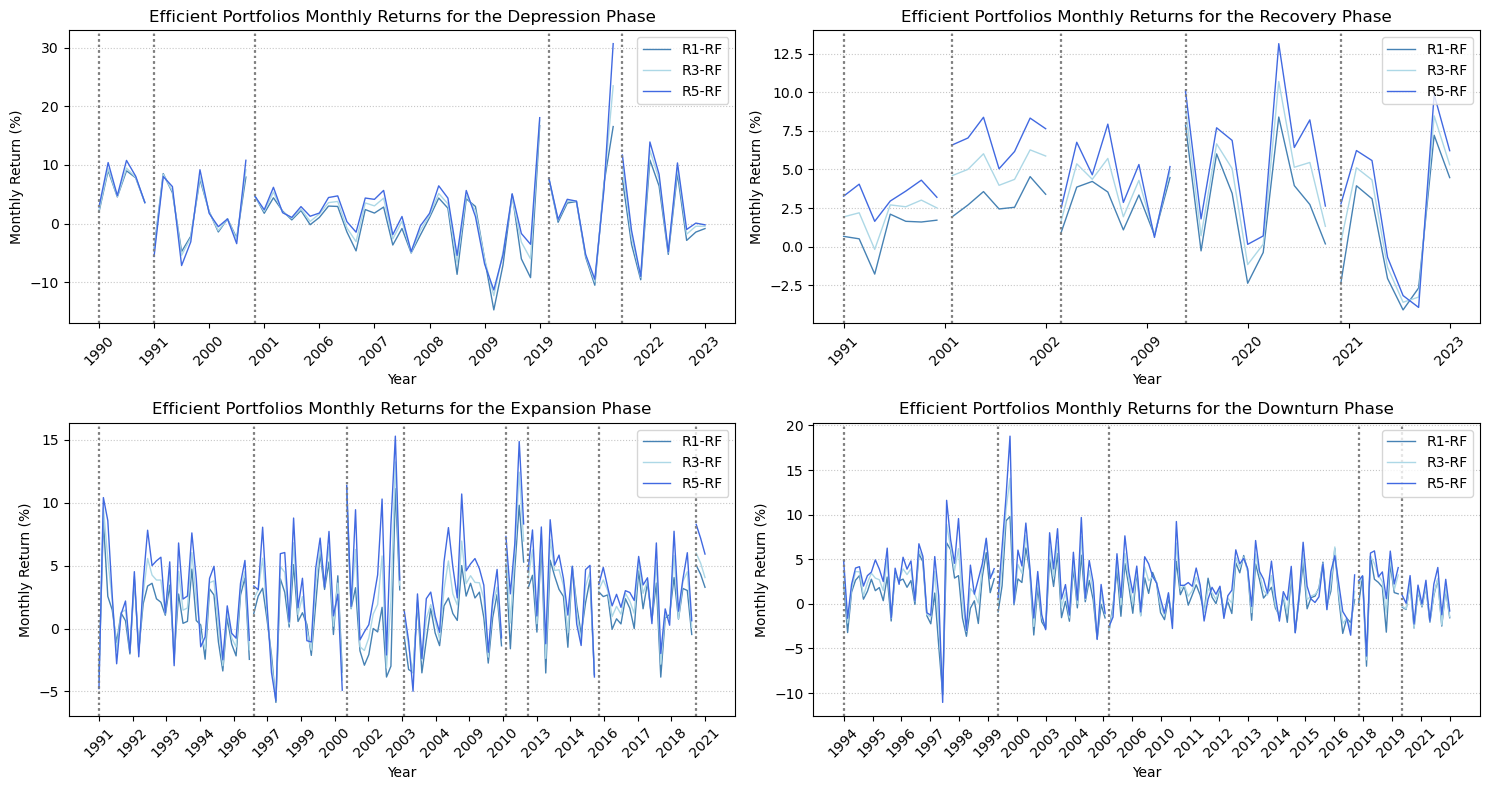

In [41]:
# Create Year column for monthly data
phase_pfo_m = combined_m[['Phase', 'Year_Month', 'R1-RF', 'R3-RF', 'R5-RF']].copy()
phase_pfo_m['Year'] = phase_pfo_m['Year_Month'].str.split('-').str[0]
phases = ['Depression', 'Recovery', 'Expansion', 'Downturn']

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()
colors = {'R1-RF': 'steelblue', 'R3-RF': 'lightblue', 'R5-RF': 'royalblue'}
# Loop over phases
for i, phase in enumerate(phases):
    phase_data = phase_pfo_m[phase_pfo_m['Phase'] == phase].copy()
    phase_data['Year'] = pd.to_numeric(phase_data['Year'])
    for column in ['R1-RF', 'R3-RF', 'R5-RF']:
        plotted = False
        for _, group in phase_data.groupby(phase_data['Year'].diff().gt(1).cumsum()):
            if not plotted:
                axes[i].plot(group['Year_Month'], group[column], color=colors[column], label=column, linewidth=1)
                plotted = True
            else:
                axes[i].plot(group['Year_Month'], group[column], color=colors[column], linewidth=1)
            # Plot vertical dotted line at year jump
            if len(group) > 1:
                year_jump_point = group['Year_Month'].iloc[0]
                axes[i].axvline(x=year_jump_point, color='grey', linestyle='dotted')                
    # Setting labels and titles for subplots
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Monthly Return (%)')
    axes[i].set_title(f'Efficient Portfolios Monthly Returns for the {phase} Phase')
    # Customizing x-axis to show only the year
    years = phase_data['Year_Month'].str[:4].unique()
    axes[i].set_xticks(np.linspace(0, len(phase_data) - 1, len(years)))
    axes[i].set_xticklabels(years, rotation=45)
    # Add grid lines and legend
    axes[i].grid(axis='y', linestyle='dotted', alpha=0.7)
    axes[i].legend()
# Save and show plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'optimal_monthly_returns_by_phase.png'))
plt.show()
